<a href="https://colab.research.google.com/github/Adrok24/Proyecto-Integrador/blob/branch_1/TVAE_corpus_v6_von_mises_fisher.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow-datasets==1.2.0

     |████████████████████████████████| 2.3MB 4.3MB/s 
  Found existing installation: tensorflow-datasets 4.0.1
    Uninstalling tensorflow-datasets-4.0.1:
      Successfully uninstalled tensorflow-datasets-4.0.1


In [9]:
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Layer, Dense, LSTM, Bidirectional, TimeDistributed
import tensorflow.keras.backend as K
import pandas as pd

tf.random.set_seed(1234)
pd.options.display.max_colwidth = 100

In [11]:
## Vamos a bajarnos el dataset de dialogos de peliculas de Cornell University
# folder = '/content/drive/My Drive/My Drive/Colab Notebooks/desafio final/'
folder = '/content/drive/My Drive/My Drive/Colab Notebooks/desafio final/'

path_to_corpus = os.path.join(folder, 'train_corpus_v2.csv')
path_to_corpus

'/content/drive/My Drive/My Drive/Colab Notebooks/desafio final/train_corpus_v2.csv'

In [12]:
data = pd.read_csv(path_to_corpus, index_col=0)

In [13]:
data.sample(10)

,line,len,book,genre,category
94749,la miró directamente a los ojos y por una vez el miedo hizo presa de su corazón,81,do_late_un_corazon_-_Danielle_Steel,Novelas,Book
1928,cada escritor pues de ellos seguimos hablando ahora alcanza o no alcanza a su manera el lugar y ...,108,Obra_critica_I_-_Julio_Cortazar,cortazar,Book
196692,"@name salió disparado , como un pelele , yendo a caer sobre los que se agrupaban en la puert...",139,Jaque_de_rufianes_-_A._Rolcest,Novelas,Book
248407,"no haberte visto le rompería el corazón , pero quería verte a solas",71,Ecos_-_Danielle_Steel,Novelas,Book
19714,son capaces de hacer hablar a un personaje de dostoievski como si fuera @name sorel o rastignac,97,Cartas_1955-1964_-_Julio_Cortazar,cortazar,Book
280935,"@name creía que su marido era un poco estirado , pero sobre gustos no hay nada escrito",90,El_rancho_-_Danielle_Steel,Novelas,Book
143328,"aunque después de retar a @name , te burles del capitán ranger . .",74,La_captura_de_la_fiera_-_A._Rolcest,Novelas,Book
314056,"por ese servicio , te regalo la vida . .",48,La_ley_en_el_revolver_-_A._Rolcest,Novelas,Book
73727,igual que una tela suave que cae lentamente en la cara del destino,68,_frente_al_espejo_-_Denis_Hernandez,poesía,Book
29418,"al morir , en @number , tenía treinta y un años",53,Obra_critica_II_-_Julio_Cortazar,cortazar,Book


In [14]:
data.shape

(316618, 5)

In [15]:
data.iloc[0:5,0]

0             bestiario es el primer libro de relatos que @name cortázar publica con su auténtico nombre
2    sorpresa o incomodidad son  ,  en cada texto  ,  un condimento que se agrega al placer indescrip...
4                                                                 a @name  ,  que gustaba de mis relatos
5    almorzábamos a mediodía  ,  siempre puntuales ya no quedaba nada por hacer fuera de unos pocos p...
6    nos resultaba grato almorzar pensando en la casa profunda y silenciosa y cómo nos bastábamos par...
Name: line, dtype: object

In [16]:
## tokenizador de subwords
tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    data.iloc[:,0].tolist(), target_vocab_size=2**13)

### Preprocesamiento

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data['line'], data['genre'], test_size=0.20, random_state=42, stratify=data['genre'])
print('X_train: ',X_train.shape, 'X_test: ',X_test.shape, 'y_train: ',y_train.shape, 'y_test: ',y_test.shape)

X_train:  (253294,) X_test:  (63324,) y_train:  (253294,) y_test:  (63324,)


In [18]:
data_train = pd.concat([X_train, y_train],axis=1)

In [19]:
VOCAB_SIZE = tokenizer.vocab_size

In [20]:
## el tokenizador tiene dos metodos: encode y decode:
print(tokenizer.encode("cantar"))
print(tokenizer.decode(tokenizer.encode("cantar")))

[4969]
cantar


In [21]:
sample_string = 'todo lo que nos desvela'

tokenized_string = tokenizer.encode(sample_string)
print ('Tokenizada {}'.format(tokenized_string))

original_string = tokenizer.decode(tokenized_string)
print ('Original: {}'.format(original_string))

for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer.decode([ts])))

assert original_string == sample_string

Tokenizada [50, 14, 3, 74, 3740, 778]
Original: todo lo que nos desvela
50 ----> todo 
14 ----> lo 
3 ----> que 
74 ----> nos 
3740 ----> desv
778 ----> ela


In [22]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64
MAX_LENGTH = 32

In [23]:
# Funcion para utilizar luego en la reconstrucción
def tokenize_and_filter(inputs):
  tokenized_inputs = []
  
  for sentence1 in inputs:
    # tokenizamos + tokens especiales
    sentence1 = tokenizer.encode(sentence1)
    # filtramos
    if len(sentence1) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
  
  # paddeamos
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs

In [24]:
# Tokenizamos, filtramos las secuencias menores al largo maximo
# y las paddeamos 
def tokenize_and_filter_df(inputs):
  tokenized_inputs = {}
  count_dict = 0
  for index, line in inputs.iterrows():
    sentence = line['line']
    # tokenizamos + tokens especiales
    sentence = tokenizer.encode(sentence)
    # filtramos
    if len(sentence) <= MAX_LENGTH:
      # tokenized_inputs.append(sentence)
      tokenized_inputs[count_dict] = {"line": sentence, "len": len(sentence), "genre": line['genre']}
      count_dict += 1

  data_filtered = pd.DataFrame.from_dict(tokenized_inputs, "index")
  
  return data_filtered

data_tokens = tokenize_and_filter_df(data_train)

In [25]:
data_tokens

,line,len,genre
0,"[64, 7234, 8030, 1522, 6949, 7965, 29, 81, 3434, 2, 5241, 66]",12,Novelas
1,"[614, 3, 282, 7038, 664, 28, 2, 192, 2858, 20, 5856, 20, 6, 4792, 2944, 14, 13, 1079, 2725, 8044]",20,Novelas
2,"[22, 456, 385, 2034, 53, 73, 18, 1267]",8,Novelas
3,"[280, 4, 5900, 7965, 2, 7126, 106, 6, 975, 479]",10,cortazar
4,"[10, 7740, 104, 5, 175, 4138, 100, 2, 255, 241]",10,Novelas
...,...,...,...
249844,"[7997, 9, 14, 429, 173, 13, 7326, 6, 218, 10, 4189, 2, 1516]",13,Novelas
249845,"[65, 1113, 62, 5110, 2, 157, 8030, 12, 9, 38, 11, 540, 2499, 7, 175, 4, 1105]",17,Novelas
249846,"[7997, 9, 446, 29, 43, 5299, 20, 26, 123, 4, 285, 3, 1858, 18, 317]",15,Novelas
249847,"[5168, 3869, 10, 4, 1387, 1732, 450, 2, 21, 4857, 2002, 23, 6350, 2000, 5862, 16, 8, 436, 5, 13,...",22,filosofia


In [26]:
# paddeamos
data_lines = tf.keras.preprocessing.sequence.pad_sequences(
    data_tokens.line.tolist(), maxlen=MAX_LENGTH, padding='post')
  
data_lines[0]

array([  64, 7234, 8030, 1522, 6949, 7965,   29,   81, 3434,    2, 5241,
         66,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
      dtype=int32)

In [27]:
print('Tamaño vocabulario: {}'.format(VOCAB_SIZE))
print('frases: {}'.format(len(data_lines)))

Tamaño vocabulario: 8189
frases: 249849


In [28]:
# Tomamos la mayor cantidad de frases que sea multiplo de [BATCH_SIZE] para no generar problemas en el entrenamiento
FINAL_LINES = int(len(data_lines) / BATCH_SIZE) * BATCH_SIZE
FINAL_LINES

249792

In [29]:
# Adapto para que de un multiplo del batch size (64)
data_lines = data_lines[0:FINAL_LINES]
len(data_lines)

249792

In [30]:
# saco el token de start de los outputs
dataset = tf.data.Dataset.from_tensor_slices((data_lines,data_lines))

dataset = dataset.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE)
#dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

### Elementos básicos

In [31]:
def scaled_dot_product_attention(query, key, value, mask):
  """Calculamos attention weights """

  ## hacemos el producto de query por la transpuesta de key
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  ## escalamos por la raiz cuadrado del # dims
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  ## agregamos la mascara
  if mask is not None:
    logits += (mask * -1e9)

  ## aplicamos la softmax
  attention_weights = tf.nn.softmax(logits, axis=-1)

  ## y multiplicamos por value 
  output = tf.matmul(attention_weights, value)

  return output

In [32]:
class MultiHeadAttention(tf.keras.layers.Layer):

  ''' Vamos a armar la capa para multihead attention '''

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)

    ## que es este super?
    ## super() te permite acceeder a los metodos de la super clase de la cual
    ## la subclase está heredando. En este caso, estas herendando de Layers.
        
    ## definimos algunos parametros: cuantas cabezas va a tener self attention 
    ## y la dimensionalidad del embedding
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    ## cuantas dimensiones va a tener cada cabeza:
    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    ## vamos a armar la division en cabezas. 
    ## se va a entender mejor en el siguiente bloque de codigo
    ## por ahora es solamente la forma en la que 
    ## reacomodamos los datos para armar las cabezas
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])


  def get_config(self):
          config = super().get_config().copy()
          config.update({
              'num_heads': self.num_heads,
              'd_model': self.d_model,
              'depth': self.depth,
              'query_dense': self.query_dense,
              'key_dense': self.key_dense,
              'value_dense': self.value_dense,
              'dense': self.dense             
          })
          return config

  def call(self, inputs):
    ''' Este call es el metodo que  va a llamar keras para usar la capa'''

    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # linear layers
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # print(self.name, mask)

    # split heads
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # scaled dot-product attention
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    # acomodamos las dimensiones
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # concatenamos las cabezas
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # final linear layer
    outputs = self.dense(concat_attention)

    return outputs

In [33]:
## creamos una mascara para el padding (asi nos nos molesta)
## con esto lo que hacemos es despues pasarselo a la capa 
## anterior y eliminamos los paddings

def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)

  return mask[:, tf.newaxis, tf.newaxis, :]

In [34]:
## vamos a crear la otra mascara:
## ahora queremos la mascara para no ver el futuro
## vamos a incorporarle tambien la mascara para el padding

def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)

  ## aca la mascara para el padding
  padding_mask = create_padding_mask(x)

  return tf.maximum(look_ahead_mask, padding_mask)

In [172]:
class PositionalEncoding(tf.keras.layers.Layer):
  ''' Armamos los encodings de posición '''

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  ## comparar con formula de la teorica
  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

   
  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)
    # seno a los indices pares
    sines = tf.math.sin(angle_rads[:, 0::2])
    # coseno a los impares
    cosines = tf.math.cos(angle_rads[:, 1::2])

    pos_encoding = tf.concat([sines, cosines], axis=-1)
    pos_encoding = pos_encoding[tf.newaxis, :]
    return tf.cast(pos_encoding, tf.float32)

  def get_config(self):

          config = super().get_config().copy()
          config.update({
              'pos_encoding': self.pos_encoding
          })
          return config

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

### Encoder

In [299]:
"""The Hyperspherical Uniform distribution class."""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import math

from tensorflow.python.framework import constant_op
from tensorflow.python.framework import dtypes
from tensorflow.python.framework import ops
from tensorflow.python.framework import tensor_shape
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import check_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import random_ops
import tensorflow_probability as tfp
from tensorflow.python.ops.distributions import distribution

from tensorflow.python.ops import nn_impl
from tensorflow.python.framework.tensor_shape import TensorShape
from tensorflow.python.ops import gen_math_ops


class HypersphericalUniform(distribution.Distribution):
    """Hyperspherical Uniform distribution with `dim` parameter.
    #### Mathematical Details
    """

    def __init__(self, dim, dtype=dtypes.float32, validate_args=False, allow_nan_stats=True,
                 name="HypersphericalUniform"):
        """Initialize a batch of Hyperspherical Uniform distributions.
        Args:
          dim: Integer tensor, dimensionality of the distribution(s). Must
            be `dim > 0`.
          validate_args: Python `bool`, default `False`. When `True` distribution
            parameters are checked for validity despite possibly degrading runtime
            performance. When `False` invalid inputs may silently render incorrect
            outputs.
          allow_nan_stats: Python `bool`, default `True`. When `True`, statistics
            (e.g., mean, mode, variance) use the value "`NaN`" to indicate the
            result is undefined. When `False`, an exception is raised if one or
            more of the statistic's batch members are undefined.
          name: Python `str` name prefixed to Ops created by this class.
        Raises:
          InvalidArgumentError: if `dim > 0` and `validate_args=False`.
        """
        parameters = locals()
        with ops.name_scope(name, values=[dim]):
            with ops.control_dependencies([check_ops.assert_positive(dim),
                                           check_ops.assert_integer(dim),
                                           check_ops.assert_scalar(dim)] if validate_args else []):
                self._dim = dim

            super(HypersphericalUniform, self).__init__(
                dtype=dtype,
                reparameterization_type=tfp.distributions.FULLY_REPARAMETERIZED,
                validate_args=validate_args,
                allow_nan_stats=allow_nan_stats,
                parameters=parameters,
                graph_parents=[],
                name=name)

    @staticmethod
    def _param_shapes(sample_shape):
        return {}

    @property
    def dim(self):
        """Dimensionality of the distribution(s)."""
        return self._dim

    def _batch_shape_tensor(self):
        return constant_op.constant([self._dim + 1], dtype=dtypes.int32)

    def _batch_shape(self):
        return TensorShape(self._dim + 1)

    def _event_shape_tensor(self):
        return constant_op.constant([], dtype=dtypes.int32)

    def _event_shape(self):
        return tensor_shape.TensorShape([])

    def _sample_n(self, n, seed=None):
        return nn_impl.l2_normalize(random_ops.random_normal(shape=array_ops.concat(([n], [self._dim + 1]), 0),
                                                             dtype=self.dtype, seed=seed), axis=-1)

    def _log_prob(self, x):
        return - array_ops.ones(shape=array_ops.shape(x)[:-1], dtype=self.dtype) * self.__log_surface_area()

    def _prob(self, x):
        return math_ops.exp(self._log_prob(x))

    def _entropy(self):
        return self.__log_surface_area()

    def __log_surface_area(self):
        return math.log(2) + ((self._dim + 1) / 2) * math.log(math.pi) - gen_math_ops.lgamma(
            math_ops.cast((self._dim + 1) / 2, dtype=self.dtype))

In [300]:
# Copyright 2016 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
"""The exponentially scaled modified Bessel function of the first kind."""

import numpy as np
import scipy.special

from tensorflow.python.ops import script_ops
from tensorflow.python.ops import array_ops
from tensorflow.python.framework import dtypes
from tensorflow.python.framework import ops
from tensorflow.python.ops.custom_gradient import custom_gradient


@custom_gradient
def ive(v, z):
    """Exponentially scaled modified Bessel function of the first kind."""
    output = array_ops.reshape(script_ops.py_func(
        lambda v, z: np.select(condlist=[v == 0, v == 1],
                               choicelist=[scipy.special.i0e(z, dtype=z.dtype),
                                           scipy.special.i1e(z, dtype=z.dtype)],
                               default=scipy.special.ive(v, z, dtype=z.dtype)), [v, z], z.dtype),
        ops.convert_to_tensor(array_ops.shape(z), dtype=dtypes.int32))

    def grad(dy):
        return None, dy * (ive(v - 1, z) - ive(v, z) * (v + z) / z)

    return output, grad

In [301]:
# Copyright 2016 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
"""The von-Mises-Fisher distribution class."""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import math

from tensorflow.python.framework import constant_op
from tensorflow.python.framework import dtypes
from tensorflow.python.framework import ops
from tensorflow.python.framework import tensor_shape
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import check_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import random_ops

import tensorflow_probability as tfp

#from tensorflow.python.ops.distributions import distribution
from tensorflow.python.ops.distributions import kullback_leibler

from tensorflow.python.ops import control_flow_ops
from tensorflow.python.ops import gen_math_ops
from tensorflow.python.ops import gen_array_ops
from tensorflow.python.ops import linalg_ops
from tensorflow.python.ops import nn_impl
from tensorflow.python.ops.distributions.beta import Beta



__all__ = [
    "VonMisesFisher",
]


class VonMisesFisher(distribution.Distribution):
    """The von-Mises-Fisher distribution with location `loc` and `scale` parameters.
    #### Mathematical details
    
    The probability density function (pdf) is,
    
    ```none
    pdf(x; mu, k) = exp(k mu^T x) / Z
    Z = (k ** (m / 2 - 1)) / ((2pi ** m / 2) * besseli(m / 2 - 1, k))
    ```
    where `loc = mu` is the mean, `scale = k` is the concentration, `m` is the dimensionality, and, `Z`
    is the normalization constant.
    
    See https://en.wikipedia.org/wiki/Von_Mises-Fisher distribution for more details on the 
    Von Mises-Fiser distribution.
    
    """

    def __init__(self, loc, scale, validate_args=False, allow_nan_stats=True, name="von-Mises-Fisher"):
        """Construct von-Mises-Fisher distributions with mean and concentration `loc` and `scale`.
        Args:
          loc: Floating point tensor; the mean of the distribution(s).
          scale: Floating point tensor; the concentration of the distribution(s).
            Must contain only non-negative values.
          validate_args: Python `bool`, default `False`. When `True` distribution
            parameters are checked for validity despite possibly degrading runtime
            performance. When `False` invalid inputs may silently render incorrect
            outputs.
          allow_nan_stats: Python `bool`, default `True`. When `True`,
            statistics (e.g., mean, mode, variance) use the value "`NaN`" to
            indicate the result is undefined. When `False`, an exception is raised
            if one or more of the statistic's batch members are undefined.
          name: Python `str` name prefixed to Ops created by this class.
        Raises:
          TypeError: if `loc` and `scale` have different `dtype`.
        """
        parameters = locals()
        with ops.name_scope(name, values=[loc, scale]):
            with ops.control_dependencies([check_ops.assert_positive(scale),
                                           check_ops.assert_near(linalg_ops.norm(loc, axis=-1), 1, atol=1e-7)]
                                          if validate_args else []):
                self._loc = array_ops.identity(loc, name="loc")
                self._scale = array_ops.identity(scale, name="scale")
                check_ops.assert_same_float_dtype([self._loc, self._scale])

        super(VonMisesFisher, self).__init__(
            dtype=self._scale.dtype,
            reparameterization_type=distribution.FULLY_REPARAMETERIZED,
            validate_args=validate_args,
            allow_nan_stats=allow_nan_stats,
            parameters=parameters,
            graph_parents=[self._loc, self._scale],
            name=name)

        self.__m = math_ops.cast(self._loc.shape[-1], dtypes.int32)
        self.__mf = math_ops.cast(self.__m, dtype=self.dtype)
        self.__e1 = array_ops.one_hot([0], self.__m, dtype=self.dtype)

    @staticmethod
    def _param_shapes(sample_shape):
        return dict(zip(("loc", "scale"), ([ops.convert_to_tensor(sample_shape, dtype=dtypes.int32),
                                            ops.convert_to_tensor(sample_shape[:-1].concatenate([1]),
                                                                  dtype=dtypes.int32)])))

    @property
    def loc(self):
        """Distribution parameter for the mean."""
        return self._loc

    @property
    def scale(self):
        """Distribution parameter for concentration."""
        return self._scale

    def _batch_shape_tensor(self):
        return array_ops.broadcast_dynamic_shape(
            array_ops.shape(self._loc),
            array_ops.shape(self._scale))

    def _batch_shape(self):
        return array_ops.broadcast_static_shape(
            self._loc.get_shape(),
            self._scale.get_shape())

    def _event_shape_tensor(self):
        return constant_op.constant([], dtype=dtypes.int32)

    def _event_shape(self):
        return tensor_shape.TensorShape([])

    def _sample_n(self, n, seed=None):
        shape = array_ops.concat([[n], self.batch_shape_tensor()], 0)
        w = control_flow_ops.cond(gen_math_ops.equal(self.__m, 3),
                                  lambda: self.__sample_w3(n, seed),
                                  lambda: self.__sample_w_rej(n, seed))

        v = nn_impl.l2_normalize(array_ops.transpose(
            array_ops.transpose(random_ops.random_normal(shape, dtype=self.dtype, seed=seed))[1:]), axis=-1)

        x = array_ops.concat((w, math_ops.sqrt(1 - w ** 2) * v), axis=-1)
        z = self.__householder_rotation(x)

        return z

    def __sample_w3(self, n, seed):
        shape = array_ops.concat(([n], self.batch_shape_tensor()[:-1], [1]), 0)
        u = random_ops.random_uniform(shape, dtype=self.dtype, seed=seed)
        self.__w = 1 + math_ops.reduce_logsumexp([math_ops.log(u), math_ops.log(1 - u) - 2 * self.scale], axis=0) / self.scale
        return self.__w

    def __sample_w_rej(self, n, seed):
        c = math_ops.sqrt((4 * (self.scale ** 2)) + (self.__mf - 1) ** 2)
        b_true = (-2 * self.scale + c) / (self.__mf - 1)
        
        # using Taylor approximation with a smooth swift from 10 < scale < 11
        # to avoid numerical errors for large scale
        b_app = (self.__mf - 1) / (4 * self.scale)
        s = gen_math_ops.minimum(gen_math_ops.maximum(0., self.scale - 10), 1.)
        b = b_app * s + b_true * (1 - s)
        
        a = (self.__mf - 1 + 2 * self.scale + c) / 4
        d = (4 * a * b) / (1 + b) - (self.__mf - 1) * math_ops.log(self.__mf - 1)

        self.__b, (self.__e, self.__w) = b, self.__while_loop(b, a, d, n, seed)
        return self.__w

    def __while_loop(self, b, a, d, n, seed):
        def __cond(w, e, bool_mask, b, a, d):
            return math_ops.reduce_any(bool_mask)

        def __body(w_, e_, bool_mask, b, a, d):
            e = math_ops.cast(Beta((self.__mf - 1) / 2, (self.__mf - 1) / 2).sample(
                shape, seed=seed), dtype=self.dtype)

            u = random_ops.random_uniform(shape, dtype=self.dtype, seed=seed)

            w = (1 - (1 + b) * e) / (1 - (1 - b) * e)
            t = (2 * a * b) / (1 - (1 - b) * e)

            accept = gen_math_ops.greater(((self.__mf - 1) * math_ops.log(t) - t + d), math_ops.log(u))
            reject = gen_math_ops.logical_not(accept)

            w_ = array_ops.where(gen_math_ops.logical_and(bool_mask, accept), w, w_)
            e_ = array_ops.where(gen_math_ops.logical_and(bool_mask, accept), e, e_)
            bool_mask = array_ops.where(gen_math_ops.logical_and(bool_mask, accept), reject, bool_mask)

            return w_, e_, bool_mask, b, a, d

        shape = array_ops.concat([[n], self.batch_shape_tensor()[:-1], [1]], 0)
        b, a, d = [gen_array_ops.tile(array_ops.expand_dims(e, axis=0), [n] + [1] * len(e.shape)) for e in (b, a, d)]

        w, e, bool_mask, b, a, d = control_flow_ops.while_loop(__cond, __body,
                                                               [array_ops.zeros_like(b, dtype=self.dtype),
                                                                array_ops.zeros_like(b, dtype=self.dtype),
                                                                array_ops.ones_like(b, dtypes.bool),
                                                                b, a, d])

        return e, w

    def __householder_rotation(self, x):
        u = nn_impl.l2_normalize(self.__e1 - self._loc, axis=-1)
        z = x - 2 * math_ops.reduce_sum(x * u, axis=-1, keepdims=True) * u
        return z

    def _log_prob(self, x):
        return self._log_unnormalized_prob(x) - self._log_normalization()

    def _prob(self, x):
        return math_ops.exp(self._log_prob(x))

    def _log_unnormalized_prob(self, x):
        with ops.control_dependencies(
                [check_ops.assert_near(linalg_ops.norm(x, axis=-1), 1, atol=1e-3)] if self.validate_args else []):
            output = self.scale * math_ops.reduce_sum(self._loc * x, axis=-1, keepdims=True)

        return array_ops.reshape(output, ops.convert_to_tensor(array_ops.shape(output)[:-1]))

    def _log_normalization(self):
        output = -((self.__mf / 2 - 1) * math_ops.log(self.scale) - (self.__mf / 2) * math.log(2 * math.pi) - (
                    self.scale + math_ops.log(ive(self.__mf / 2 - 1, self.scale))))

        return array_ops.reshape(output, ops.convert_to_tensor(array_ops.shape(output)[:-1]))

    def _entropy(self):
        return - array_ops.reshape(self.scale * ive(self.__mf / 2, self.scale) / ive((self.__mf / 2) - 1, self.scale),
                                   ops.convert_to_tensor(array_ops.shape(self.scale)[:-1])) + self._log_normalization()

    def _mean(self):
        return self._loc * (ive(self.__mf / 2, self.scale) / ive(self.__mf / 2 - 1, self.scale))

    def _mode(self):
        return self._mean()


@kullback_leibler.RegisterKL(VonMisesFisher, HypersphericalUniform)
def _kl_vmf_uniform(vmf, hyu, name=None):
    with ops.control_dependencies([check_ops.assert_equal(vmf.loc.shape[-1] - 1, hyu.dim)]):
        with ops.name_scope(name, "_kl_vmf_uniform", [vmf.scale]):
            return - vmf.entropy() + hyu.entropy()

In [302]:
class Sampling(Layer):
    def call(self, inputs):
      mu, log_var = inputs
      #  epsilon = K.random_normal(shape=K.shape(mu), mean=0., stddev=1.)
      #  return mu + K.exp(log_var / 2) * epsilon
      q_z = VonMisesFisher(mu, log_var)

      return  q_z.sample()

In [303]:
## ya tenemos todos los ingredientes para armar una capa de encoder
## todavía no es el encoder entero!

def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [304]:
## ahora si: el encoder
## vamos a definir una funcion que nos devuelva un modelo que tenga
## num_layers bloques de encoder:

def encoder(vocab_size, num_layers, units, d_model, num_heads,
            dropout, latent_space, name="encoder"):
  
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  print('enc_inputs',inputs)

  padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  ## partimos de los embeddings
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  ## y les sumamos el positional encoding
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  ## y usamos tantos bloques como querramos
  for i in range(num_layers):
    outputs = encoder_layer(
                            units=units,
                            d_model=d_model,
                            num_heads=num_heads,
                            dropout=dropout,
                            name="encoder_layer_{}".format(i),
                        )([outputs, padding_mask])

  outputs  = tf.keras.layers.Reshape([MAX_LENGTH * d_model])(outputs)
  # Generamos la media
  
  outputs = tf.keras.layers.Dense(MAX_LENGTH * 10)(outputs)

  outputs = tf.keras.layers.Dense(latent_space)(outputs)
  

  mu = Dense(latent_space, name='mu',activation=lambda x: tf.nn.l2_normalize(x, axis=-1))(outputs) #TODO: revisar la dimensionalidad del espacio latente
            # the `+ 1` prevent collapsing behaviors

  # Generamos el logaritmo de la varianza
  logvar = Dense(1, name='logvar',activation=tf.nn.softplus)(outputs)+1
  # Usamos esos parámetros para samplear el espacio latente
  z = Sampling(name='encoder_output')([mu, logvar])

  #output = Dense(d_model, name='latent space')(outputs)

  return tf.keras.Model(
      inputs=inputs, outputs=[mu, logvar, z], name=name)

### Decoder

In [305]:
## vamos a usar las mismas partes que ya tenemos para armar el decoder
## primero la decoder layer

def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  
  decoder_input = tf.keras.Input(shape=(None, d_model), name="decoder_input_layer")
  
  # look_ahead_mask = tf.keras.Input(
  #     shape=(1, None, None), name="look_ahead_mask")

  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': decoder_input,
          'key': decoder_input,
          'value': decoder_input,
          'mask': None #padding_mask
      })

  #Normalization1
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + decoder_input)

  #FeedFoward
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention1)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)

  #Normalization2
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention1)

  return tf.keras.Model(
      inputs=[decoder_input],
      outputs=outputs,
      name=name)

In [306]:
## y ahora usamos la decoder layer para el decoder

def decoder(vocab_size, num_layers, units, d_model, num_heads,
            dropout ,latent_space, name='decoder'):

  decoder_input = tf.keras.Input(shape=(latent_space), name='decoder_input')

  output = tf.keras.layers.Dense(MAX_LENGTH * 10)(decoder_input)

  
  output = Dense(MAX_LENGTH * d_model, name='linear_proyection')(output)

  output = tf.keras.layers.Reshape([MAX_LENGTH, d_model])(output)
 # print('linear_proyection', output.shape)

  ## la mascara para no ver el futuro y para el padding
  ## ojo que la toma de afuera (es un input, no la creamos aca)

  # look_ahead_mask = tf.keras.Input(
  #     shape=(1, None, None), name='look_ahead_mask')
  

  outputs = tf.keras.layers.Dropout(rate=dropout)(output)

  ## vamos a tener num_layers bloques de decoders
  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs])

  outputs = tf.keras.layers.TimeDistributed(Dense(d_model))(outputs)
  outputs = tf.keras.layers.LSTM(units=d_model, return_sequences=True, name='LSTM')(outputs)


  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(outputs)

#  print('final', output.shape)

  return tf.keras.Model(
      inputs=[decoder_input],
      outputs=outputs,
      name=name)

### Modelo VAE

In [317]:
from tensorflow.keras.models import Model
from contextlib import suppress


beta = K.variable(value=0.0)
beta._trainable = False

class VAEModel(Model):
    def __init__(self, encoder, decoder, a, b, vocab_size, num_layers, units, d_model, num_heads, dropout, latent_space, mask=None, function=None, **kwargs):
        super(VAEModel, self).__init__(**kwargs)
        self.encoder = encoder(
          vocab_size=vocab_size,
          num_layers=num_layers,
          units=units,
          d_model=d_model,
          num_heads=num_heads,
          dropout=dropout,
          latent_space=latent_space)
        
        self.decoder = decoder(
          vocab_size=vocab_size,
          num_layers=num_layers,
          units=units,
          d_model=d_model,
          num_heads=num_heads,
          dropout=dropout,
          latent_space=latent_space)
        
        self.a = a
        self.b = b
        self.function = function

    def loss_function(self, y_true, y_pred):
      print("ytrue:",y_true,"ypred:",y_pred)
      y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH)) #(-1, MAX_LENGTH - 1))
      
      ## calculamos la loss sin reducir
      loss = tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True, reduction='none')(y_true, y_pred)

      ## aplicamos una mascara
      # mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
      # loss = tf.multiply(loss, mask)

      ## y reducimos la loss
      return tf.reduce_mean(loss)

    # Definimos el train step para que utilice la función de costo compuesta por el error de reconstrucción y la divergencia KL
    def train_step(self, data):
        data = data[0]

        
        # Iniciamos el cálculo de la loss dentro del contexto que registra las operaciones para poder derivarlas
        with tf.GradientTape() as tape:
            # Usamos el encoder para mapear las oraciones al espacio latente y obtenemos los parámetros de la distribución
            
            
            z_mean, z_log_var, z = self.encoder(data)
            # Reconstruimos la oración a partir de z

            reconstruction = self.decoder(z)

            reconstruction_loss = self.loss_function(data, reconstruction)

            # Escalamos la pérdida con el r_loss_factor
           # reconstruction_loss *= self.r_loss_factor

            q_z = VonMisesFisher(z_mean, z_log_var)
            # Calculamos la divergencia KL usando la media y la varianza
            p_z = HypersphericalUniform(16 - 1)
            kl = q_z.kl_divergence(p_z)
            kl_loss = tf.reduce_mean(kl)



            

          #  kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
          #  kl_loss = tf.reduce_sum(kl_loss, axis = 1)
          #  kl_loss *= -0.5
            # Selecciona funcion de annealing
            if self.function == 'linear':
              factor = self.a * beta + self.b
            else:
              factor =  1/(1+tf.exp(-self.a*beta+self.b))

            total_loss = reconstruction_loss + kl_loss * factor

        # Calculamos los gradientes
        grads = tape.gradient(total_loss, self.trainable_weights)
        
        # Actualizamos los pesos
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        # El método train_step debe devolver un diccionario
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
            "kl_weight": factor,
        }

    def reconstruct(self, q_sample, silent_reconstruct=False, silent_orig=True):
      _,_,result = model.encoder(q_sample.reshape(1,MAX_LENGTH,1))
      #decoded from sample
      print('Reconstr: ',self.decode_sample(result, silent_reconstruct))

      # original  
      print('Original: ',tokenizer.decode([i for i in q_sample if i < tokenizer.vocab_size]))
      if (silent_orig == False):
        print(q_sample)

    def decode_sample(self, z_sampled, silent_reconstruct=False):
      result = self.decoder(z_sampled)
      with suppress(Exception):
        prediction = np.argmax(result, axis=2)

        pred = prediction[0]
        pred_to_decode = [i for i in pred if i < tokenizer.vocab_size]
        if (silent_reconstruct == False):
          print(pred_to_decode)
        return tokenizer.decode(pred_to_decode)


    def reconstruct_sentence(self, sentence, silent_reconstruct=False, silent_orig=True):
      sentence = [sentence]
      sentence = tokenize_and_filter(sentence)
      sentence = sentence.reshape(MAX_LENGTH)
      return self.reconstruct(sentence, silent_reconstruct, silent_orig)

    def call(self,inputs):
        mu, logvar, z = self.encoder(inputs)
        print("checkpoint_call")

        return self.decoder(z)

 


In [318]:
# Hyper-parameters
NUM_LAYERS = 6
D_MODEL = 256
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.2
LATENT_SPACE = 16
A = 0.01
B = 10

# Instanciamos el modelo
model = VAEModel(encoder, decoder, 
    a=A,
    b=B,
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT,
    latent_space=LATENT_SPACE)

enc_inputs KerasTensor(type_spec=TensorSpec(shape=(None, None), dtype=tf.float32, name='inputs'), name='inputs', description="created by layer 'inputs'")


In [319]:
# model.load_weights('/content/drive/My Drive/Colab Notebooks/desafio final/weights_corpus_v4.HDF5')

enc_inputs KerasTensor(type_spec=TensorSpec(shape=(None, None), dtype=tf.float32, name='inputs'), name='inputs', description="created by layer 'inputs'")


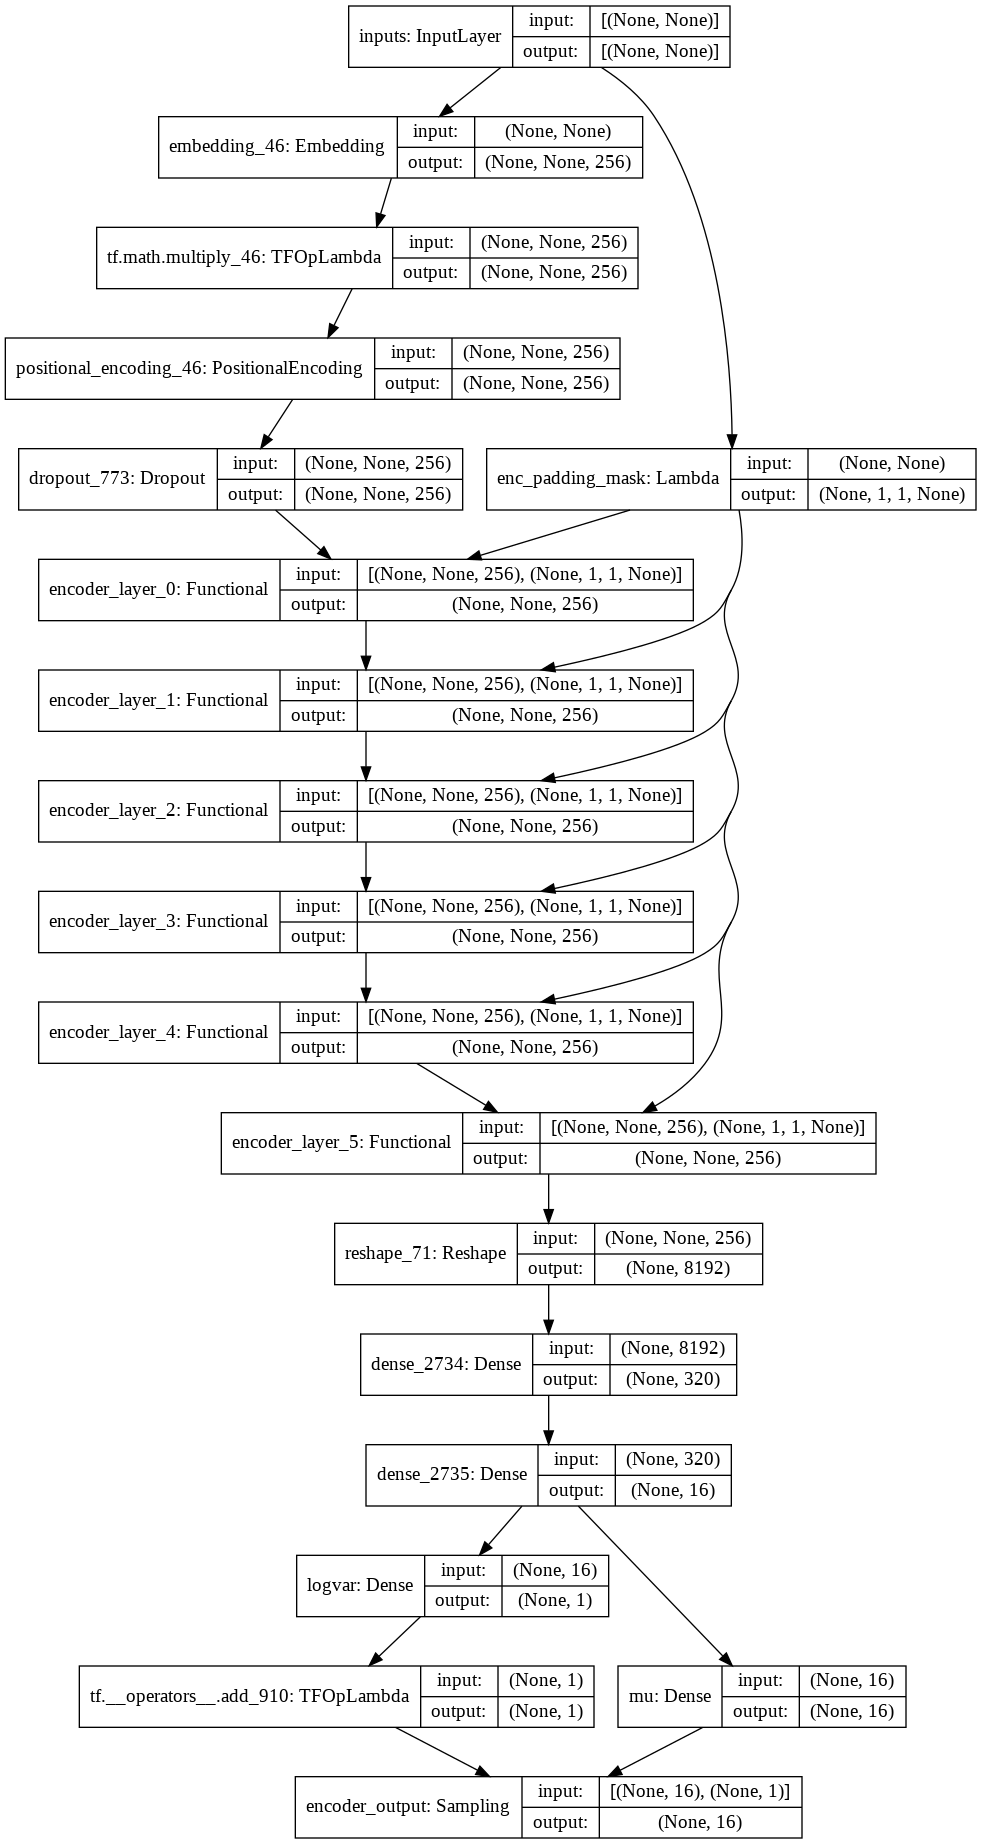

In [320]:
eo = encoder(
      vocab_size=VOCAB_SIZE,
      num_layers=NUM_LAYERS,
      units=UNITS,
      d_model=D_MODEL,
      num_heads=NUM_HEADS,
    dropout=DROPOUT,
    latent_space=LATENT_SPACE)
tf.keras.utils.plot_model(eo, show_shapes=True)

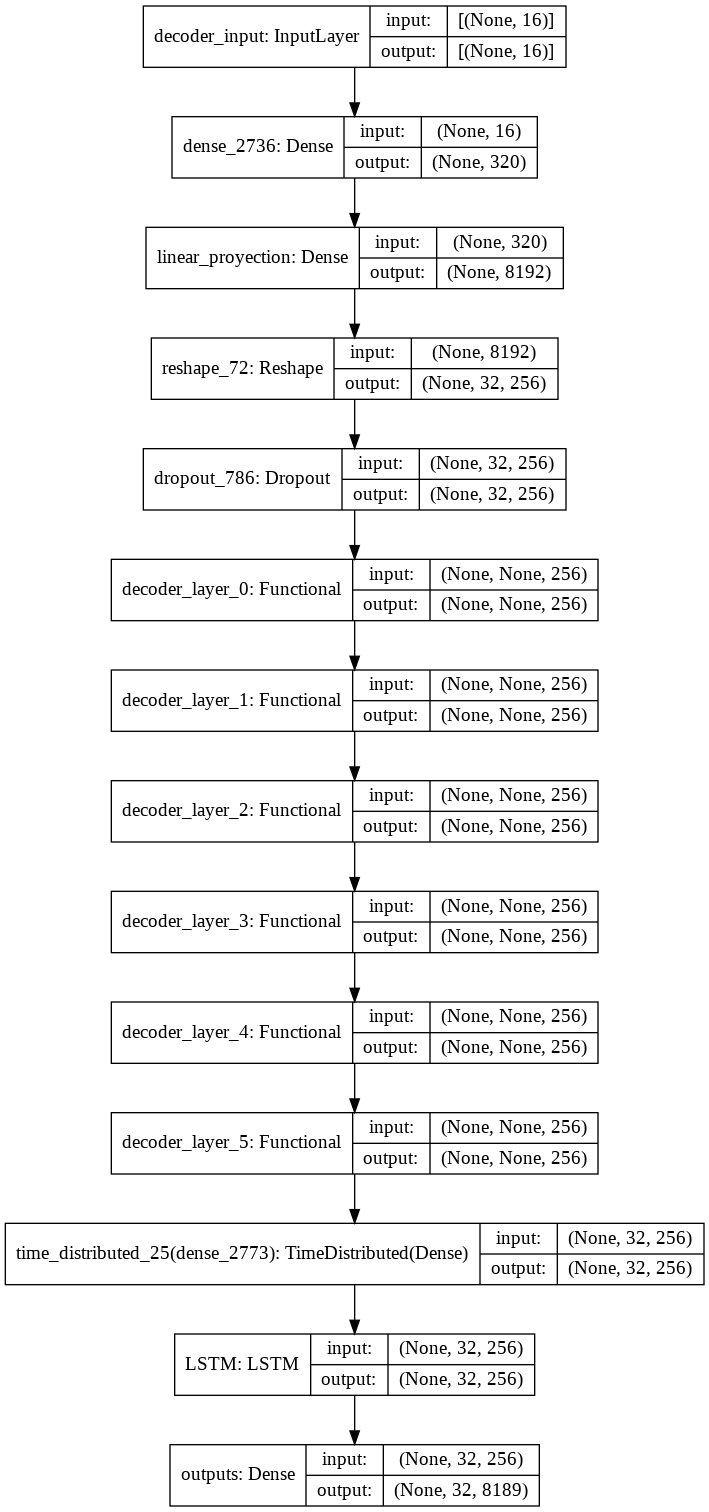

In [321]:
do = decoder(
  vocab_size=VOCAB_SIZE,
  num_layers=NUM_LAYERS,
  units=UNITS,
  d_model=D_MODEL,
  num_heads=NUM_HEADS,
  dropout=DROPOUT,
  latent_space=LATENT_SPACE)
    
tf.keras.utils.plot_model(do, show_shapes=True)
    

In [322]:
from random import randint

from nltk.translate.chrf_score import sentence_chrf

# Ejemplo de la medida del accuracy del modelo / la loss

def loss_sentence_chrf(y_true, y_pred):
  chrf_acc_mean = 0
  with suppress(Exception):
    # print(y_pred.shape)
    preds = np.argmax(y_pred, axis=-1)
    # print(preds.shape)
    chrf_acc = []
    for index, pred in enumerate(preds, start=0):
      sentence_pred = tokenizer.decode(pred)
      sentence_true = tokenizer.decode(y_true[index])
      # print(sentence_pred,"|", sentence_true)
      # print('\n')
      " ".join([str(i) for i in pred])
      sentence_pred = " ".join([str(i) for i in pred])
      sentence_true = " ".join([str(i) for i in y_true[index].numpy()])

      # print('pred:',sentence_pred)
      # print('true:',sentence_true)
      # print('\n')
      chrf_acc = sentence_chrf(sentence_pred, sentence_true, min_len=2)

      loss = (1 - chrf_acc) * 100
      # print('loss:', loss)
      # print('acc:', chrf_acc)
      # print('\n')
      chrf_acc.append(chrf_acc)
      chrf_acc_mean = tf.reduce_mean(chrf_acc_mean)
  return chrf_acc_mean


y_true = tf.constant([data_lines[randint(0,data_lines.shape[0]) - 1] for _ in range(10)])
y_pred = model.predict(y_true)

loss_sentence_chrf(y_true, y_pred)

checkpoint_call


0

In [323]:
from tensorflow.keras.callbacks import Callback, LambdaCallback


class EpochEndCallback(Callback): # Creamos una clase que herede de Callback

    def __init__(self, period=1): # Definimos los atributos que necesita la clase y los inicializamos en el constructor
        super(EpochEndCallback, self).__init__()
        self.period = period
    
    # Lo que buscamos es que cada cierta cantidad de epochs se genere un texto.
    def on_epoch_end(self, epoch, logs=None):
      if epoch % self.period == 0:
        print('Callback running', epoch)
        q_sample = data_lines[randint(0,data_lines.shape[0]) - 1]
        model.reconstruct(q_sample)
        if epoch % 20 == 0:
          model.save_weights('/content/drive/My Drive/My Drive/Colab Notebooks/desafio final/weights_corpus_v4.HDF5', save_format='tf')          
          # y_true = tf.constant([data_lines[randint(0,data_lines.shape[0]) - 1] for _ in range(100)])
          # loss_sentence_chrf(y_true, y_pred)

# Instanciamos nuestro custom callback
eec = EpochEndCallback()

### Entrenamiento

In [324]:
#defino un callback para actualizar epoch y generar variable de conteo de epochs
def count(epoch):
  K.set_value(beta, epoch)

counter = LambdaCallback(on_epoch_end=lambda epoch, log: count(epoch))

In [325]:
## nos queda armar el lr que va cambiando con el tiempo
## hay que hacer un schedule de lr:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
    




In [ ]:
EPOCHS = 120

# optimizer = tf.keras.optimizers.Adam(CustomSchedule(D_MODEL), beta_1=0.9, beta_2=0.98, 
#                                      epsilon=1e-9)

optimizer = tf.keras.optimizers.Adam(0.00001, beta_1=0.9, beta_2=0.999, 
                                     epsilon=1e-9) #for fine-tunning

model.compile(optimizer=optimizer)

history = model.fit(dataset, epochs=EPOCHS, callbacks=[eec, counter])

Epoch 1/120
ytrue: Tensor("IteratorGetNext:0", shape=(None, 32), dtype=int32) ypred: Tensor("decoder/outputs/BiasAdd:0", shape=(None, 32, 8189), dtype=float32)
ytrue: Tensor("IteratorGetNext:0", shape=(None, 32), dtype=int32) ypred: Tensor("decoder/outputs/BiasAdd:0", shape=(None, 32, 8189), dtype=float32)
3903/3903 [==============================] - 438s 107ms/step - loss: 4.5017 - reconstruction_loss: 4.5009 - kl_loss: 18.3380 - kl_weight: 4.5398e-05
Callback running 0
[0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Reconstr:  None
Original:  la miró como si le hubiera disparado un tiro  ,  pero la calma no desapareció de los ojos de amadea
Epoch 2/120
3903/3903 [==============================] - 413s 106ms/step - loss: 3.4842 - reconstruction_loss: 3.4830 - kl_loss: 27.3166 - kl_weight: 4.5398e-05
Callback running 1
[0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Reconstr:  None
Origina

In [ ]:
# Grafico funcion de annealing
x = np.linspace(0,EPOCHS,10)

y = 1/(1+tf.exp(-A*x+10))


plt.figure(figsize=(20,8))

plt.plot(x,y,label='funcion de annealing')


plt.title('Funcion de annealing')

plt.xlabel('Epochs')
plt.ylabel('y')
plt.grid(alpha=.4,linestyle='--')

plt.legend()

plt.show()

In [ ]:
reconstruction_loss = history.history['reconstruction_loss']
loss = [np.mean(x) for x in model.history.history['loss']]
kl_loss = [np.mean(x) for x in model.history.history['kl_loss']]

epochs = range(1, len(reconstruction_loss) + 1)

plt.figure(figsize=(20,8))
plt.plot(epochs, reconstruction_loss, label='reconstruction_loss')
plt.plot(epochs, loss, label='loss')
plt.plot(epochs, kl_loss, label='kl_loss')
plt.xticks(ticks=epochs)
# plt.ylim([20000, 40000])
# plt.xlim([30, 100])
plt.title('reconstruction_loss - kl_loss')
plt.legend()

plt

In [ ]:
#evolucion KL LOSS
kl_loss = [np.mean(x) for x in model.history.history['kl_loss']]

epochs = range(1, len(reconstruction_loss) + 1)

plt.figure(figsize=(20,8))
plt.plot(epochs, kl_loss, label='kl_loss')
plt.xticks(ticks=epochs)
plt.title('rkl_loss')
plt.legend()

plt

In [ ]:
# model.save_weights('/content/drive/My Drive/Colab Notebooks/desafio final/weights_corpus_v4.HDF5', save_format='tf')

## Testeamos

In [ ]:
errores = 0
for i in range(10):
  z_sampled = tf.random.normal(shape=(1,LATENT_SPACE))
  prediction = model.decode_sample(z_sampled,silent_reconstruct=True)
  if (prediction != None):
    print(prediction)
  else:
    errores += 1
print('\n')
print('\n','errores',errores)

In [ ]:
q_sample = data_lines[5]
model.reconstruct(q_sample)

In [ ]:
model.reconstruct_sentence("el devenir de los momentos")
model.reconstruct_sentence("las historias que nos contaron")
model.reconstruct_sentence("tu mirada milagrosa me salvó de su odio")
model.reconstruct_sentence("cayó como un rayo de luz que cegó al mundo") 
model.reconstruct_sentence("un hombre observaba desde el monte") 

In [ ]:
# Genera una funcion que se mueve por el espacio latente desde Oracion A hasta Oracion B
def linear_interpolate(sample1, sample2, cant_sentences = 5 ):
  print('desde:', tokenizer.decode(sample1),'\n')

  _,_,result1 = model.encoder(sample1.reshape(1,MAX_LENGTH,1))
  _,_,result2 = model.encoder(sample2.reshape(1,MAX_LENGTH,1))

  #Resto los valores del espacio latente y los divido por la cantidad de oracione que quiero generar
  vector = ((result1[0] - result2[0]).numpy()) / cant_sentences 

  for i in range(cant_sentences):
    result_int = result1 - vector * i
    print('step', str(i + 1) + ':', model.decode_sample(result_int, silent_reconstruct=True))

  print('')
  print('hasta:', tokenizer.decode(q_sample2))


In [ ]:
#Generar oraciones intermedias desde una oración A hasta una B sampleadas del entrenamiento
q_sample1 = data_lines[randint(0,data_lines.shape[0]) - 1]
q_sample2 = data_lines[randint(0,data_lines.shape[0]) - 1]

linear_interpolate(q_sample1, q_sample2,6)


# Analisis Visual del espacio latente

In [ ]:
def encode_sentence(sentence):
    sentence = [sentence]
    sentence = tokenize_and_filter(sentence)
    sentence = sentence.reshape(MAX_LENGTH)
    return sentence

In [ ]:
#Generar oraciones intermedias desde una oración A hasta una B recibidas como imput por el Usuario
q_sample1 = encode_sentence("un hombre observaba desde el monte")
q_sample2 = encode_sentence("deberas dejar cerrada aquella puerta")

linear_interpolate(q_sample1, q_sample2,5)

In [ ]:
#Generar oraciones intermedias desde una oración A hasta una B recibidas como imput por el Usuario
q_sample1 = encode_sentence("al despertarse una mañana, después de un sueño intranquilo")
q_sample2 = encode_sentence("se encontró en su cama transformado en un monstruoso insecto")

linear_interpolate(q_sample1, q_sample2,5)

In [ ]:
z_mean, _, _ = model.encoder.predict(dataset)

In [ ]:
# Analisis Visual del espacio latente
def plot_label_clusters(vae, z_mean, labels=None, z_fixed=0):
  # display a 2D plot of the digit classes in the latent space
  
  fig, axes = plt.subplots(4, 4, figsize=(16,16))
  fig.subplots_adjust(hspace=0.2)
  z = 0
  colors = ['b', 'c', 'y', 'm']
  for x in range(4):
    for y in range(4): 
      axes[x, y].scatter(z_mean[:, z_fixed], z_mean[:, z])
      axes[x, y].set_xlabel("z["+ str(z_fixed) +"] | z["+ str(z) +"]") 
      # axes[x, y].ylabel("z["+ str(i) +"]")
      z += 1



In [ ]:
plot_label_clusters(model, z_mean, data_tokens['genre'], 0)

In [ ]:
plot_label_clusters(model, z_mean, None, 5)